---
# **Sentiment Analysis**
---

---

# **1. Installation**

---

## i. Generating a reponse


In [1]:
import sys
import logging
from psutil import virtual_memory

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
ram_gb = virtual_memory().total / 1e9

In [3]:
tf_response = {
    'error': None,
    'TF version': '',
    'COLAB': None,
    'GPU': False,
    'ram_gb': ''
}

In [4]:
try:
    # drive
    from google.colab import drive
    IN_COLAB = 'google.colab' in sys.modules

    # updating tensorflow version
    %tensorflow_version 2.x

    # tensorflow-gpu & tensorflowjs
    !pip install tensorflow-gpu # !pip install tensorflow_text # I could use BERT
    !pip install tensorflowjs

    # NLP (nltk, stanza, spacy)
    !pip install nltk 
    !pip install stanza
    !pip install spacy
    !spacy download en_core_web_sm # sm md lg
    !python -m spacy download en
except OSError as error:
    # debugging error
    response['error'] = logging.debug('You are not using your specify version of TensorFlow')
    IN_COLAB = False

    # install requirements
    !pip install -r '../requirements.txt'
finally:
    tf_response['COLAB'] = IN_COLAB
    
    # Importing tensroflow core
    import tensorflow as tf
    import tensorflowjs as tfjs
    from tensorflow import keras
    from keras.utils import to_categorical

    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, GlobalMaxPool1D

    from sklearn.model_selection import train_test_split
    
    # GPU and RAM response
    if tf.config.list_physical_devices('GPU'):
        GPU = True
        tf_response['GPU'] = GPU
        tf_response['TF_version'] = tf.__version__
        
        if tf_response['COLAB'] == True:
            if gpu_info.find('failed') >= 0:
                print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator')
                print('Re-execute this cell.')
            else:
                print(gpu_info)
            
            if ram_gb < 20:
                print('To enable a high-RAM runtime, select the Runtime > "Change runtime type menu"')
                print('Select high-RAM in the runtime shape dropdown')
                print('Re-execute this cell')
                tf_response['ram_gb'] = 'low-RAM runtime'
            else:
                tf_response['ram_gb'] = 'high-RAM runtime'
            print('\nRuntime {:.2f} GB of available RAM\n'.format(ram_gb))

     |████████████████████████████████| 320.4MB 42kB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 137.3MB 21kB/s 
     |████████████████████████████████| 92kB 12.4MB/s 
     |████████████████████████████████| 256kB 50.4MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32852 sha256=14ece4767557dd782f03c939ed07889b9d24866e904b060dc82d098002bda7b6
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: tensorflow-hub 0.9.0
    Uninstalling tensorflow-hub-0.9.0:
      Successfully uninstalled tensorflow-hub-0.9.0


     |████████████████████████████████| 235kB 6.0MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [5]:
tf_response

{'COLAB': True, 'GPU': False, 'TF version': '', 'error': None, 'ram_gb': ''}

## ii. Importing modules


In [6]:
# Data analysis
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import re

%matplotlib inline

# Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from PIL import Image # Pillow with WordCloud to image manipulation

In [7]:
# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [8]:
# Stanza NLP
import stanza

stanza.download('en', package='ewt', processors='tokenize,mwt,pos,lemma', verbose=True)
stNLP = stanza.Pipeline(processors='tokenize,mwt,pos,lemma',
                      lang='en',
                      use_gpu=True)

2020-10-03 02:19:28 WARNING: Can not find mwt: ewt from official model list. Ignoring it.
2020-10-03 02:19:28 INFO: Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| pretrain  | ewt     |

2020-10-03 02:20:32 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-10-03 02:20:32 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-10-03 02:20:32 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |

2020-10-03 02:20:32 INFO: Use device: gpu
2020-10-03 02:20:32 INFO: Loading: tokenize
2020-10-03 02:20:42 INFO: Loading: pos
2020-10-03 02:20:43 INFO: Loading: lemma
2020-10-03 02:20:43 INFO: Done loading processors!


In [9]:
# testing stanza
doc = stNLP('Barack Obama was born in Hawai.')
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

word: Barack 	lemma: Barack
word: Obama 	lemma: Obama
word: was 	lemma: be
word: born 	lemma: bear
word: in 	lemma: in
word: Hawai 	lemma: Hawai
word: . 	lemma: .


In [10]:
# Spacy NLP
import spacy
spNLP = spacy.load('en_core_web_sm')
spNLP.max_length = 103950039 # or higher
# spacy.prefer_gpu() #will not work with stanza


---

# **2. Hyperparameters**

---

In [11]:
FILE = 'datasets/categories_dataset.csv'
MODEL_PATH = './models/model.h5'

In [12]:
EPOCHS = 30
BATCH_SIZE = 32

training_portion = .8
rnn_units = 64

# embedding_dim : len(words) + 1
# vocab_size : len(words.index) + 1
vocab_size = 5000

max_lenght = 30 # 200 # for padding_shape on preprocess function

trunc_type = 'post'
padding_type = 'post'
padding_shape = 30
oov_tok = '<OOV>'

In [13]:
main_labels = ['confident', 'unconfident', 
               'pos_hp', 'neg_hp', 
               'interested', 'uninterested', 
               'happy', 'unhappy', 
               'friendly', 'unfriendly', 
               'POS']
               
label_dict = dict(zip(main_labels, range(1, len(main_labels) + 1)))

In [14]:
label_dict

{'POS': 11,
 'confident': 1,
 'friendly': 9,
 'happy': 7,
 'interested': 5,
 'neg_hp': 4,
 'pos_hp': 3,
 'unconfident': 2,
 'unfriendly': 10,
 'unhappy': 8,
 'uninterested': 6}

---

# **3. Lemmatization**

---

In [15]:
# lemmatizion
# stanza
def stanza_lemma(text):
    doc = stNLP(text)
    return ' '.join([word.lemma for sent in doc.sentences for word in sent.words])

In [16]:
def nltk_lemma(text):
    lemmatizer = WordNetLemmatizer()
    lemmatizer.lemmatize(text)

---
# **4. Load dataset**
---

In [17]:
def load_clean_dataset():
    !mkdir -p datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/categories_dataset.csv -P datasets
    df = pd.read_csv('./datasets/categories_dataset.csv', encoding='utf-8', index_col=0, dtype=({'score':float}))

    print(df.head())
    x, y = df['word'], df[['category', 'POS stza']] # or POS nltk
    #x, y = np.array(x, dtype='<U33'), np.array(y, dtype='<U33')

    return x, y

---
# **5. Prepare dataset**
---

In [21]:
def preprocess(x, padding_shape=30):
    return np.array([ord(i.lower()) - ord('a')+1 if not i.isdigit() and i != ' ' else 0 for i in list(x)] + ([0] * (padding_shape - len(x))), dtype=int)

In [22]:
def prepare_dataset(labeldict : dict, test_size=.3, validation_size=.1): 
    print('preparing the dataset...\n')
    
    from sklearn import preprocessing

    # load dataset
    # split dataset (as string into panda.core.series.Serie object)
    x, y = load_clean_dataset()

    x = np.array(list(map(preprocess, x)))
    y = np.array(list(map(lambda x: labeldict[x.replace(' ', '_')], y['category'])))
    print(('y: {}').format(y))

    # create/split train, validation and test and shuffle the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=True)
    print(x.max(), x.min())

    x_train_val, x_validation, y_train_val, y_validation = train_test_split(x_train, y_train, test_size=test_size, shuffle=True)

    # pandas.core.series.Series to numpy array
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_validation, y_validation =  np.array(x_validation), np.array(y_validation)
    x_test, y_test = np.array(x_test), np.array(y_test)
    
    x_train_val, y_train_val = np.array(x_train_val), np.array(y_train_val)

    print(('\nx_train: \n{}\n\ny_train: \n{}').format(x_train_val, y_train_val))
    
    return (x_train, y_train), (x_validation, y_validation), (x_test, y_test), (x_train_val, y_train_val)

In [23]:
(x_train, y_train), (x_validation, y_validation), (x_test, y_test), (x_train_val, y_train_val) = prepare_dataset(label_dict)

preparing the dataset...

File ‘datasets/categories_dataset.csv’ already there; not retrieving.

    category          word  score  ...  POS stza  POS nlkt  POS spcy
0  confident     tolerance   2.63  ...      NOUN      NOUN      NOUN
1  confident         carry   0.46  ...      VERB      NOUN      VERB
2  confident   tranquility   1.00  ...      NOUN      NOUN      NOUN
3  confident  socontagious   2.69  ...       ADJ       ADJ       ADJ
4  confident          zeal   1.00  ...      NOUN      NOUN     PROPN

[5 rows x 14 columns]
y: [ 1  1  1 ... 10 10 10]
26 0

x_train: 
[[ 3  8  1 ...  0  0  0]
 [ 1 12  9 ...  0  0  0]
 [19  9 14 ...  0  0  0]
 ...
 [ 7 18  1 ...  0  0  0]
 [12  1  7 ...  0  0  0]
 [16 10  0 ...  0  0  0]]

y_train: 
[ 9 10  7 ...  7 10 10]


---
# **4. Build model**
---

In [31]:
def build_model(vocab_size, embedding_dim=64, input_length=30):
    print('\nbuilding the model...\n')
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=(vocab_size + 1), output_dim=embedding_dim, input_length=input_length),
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units, return_sequences=True, dropout=.2)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units, return_sequences=True, dropout=.3)),
        tf.keras.layers.GlobalMaxPool1D(),
        tf.keras.layers.Dropout(.1),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)), # instead of relu

        # softmax output layer
        tf.keras.layers.Dense(11, activation='softmax')
    ])

    # optimizer & loss
    opt = 'RMSprop' # instead of # adam # tf.optimizers.Adam(leanirning_rate=1e-4)
    loss = 'categorical_crossentropy'

    # Metrics
    # AUC: Computes the approximate AUC (Area Under the Curve) via a Riemann sum.
    # Precision: Computes the precision of the predictions with respect to the labels.
    # Recall: Computes the recall of the predictions with respect to the labels.
    metrics = ['accuracy', 'AUC', 'Precision', 'Recall']

    # compile model
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=metrics)
    
    model.summary()
    
    return model

---
# **6. Train model** 
---

In [32]:
def train(model, x_train, y_train, x_validation, y_validation,
          epochs, batch_size=32, patience=5, 
          verbose=2, monitor_es='accuracy', mode_es='auto', restore=True,
          monitor_mc='val_accuracy', mode_mc='max'):
    
    print('\ntraining...\n')
    
    # callback

    # observation:
    # test the best settings
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor_es,
                                                      verbose=1, mode=mode_es, restore_best_weights=restore,
                                                      min_delta=1e-3, patience=patience)
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint('tfjsmode.h5', monitor=monitor_mc, mode=mode_mc,      
                                                          verbose=1, save_best_only=True)

    # train model
    history = model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs, verbose=verbose,
                        validation_data=(x_validation, y_validation),
                        callbacks=[early_stopping, model_checkpoint])
    return history

---
# **7. Plotting history**
---

In [33]:
def plot_history_(history):
    fitModel_dict = history.history
    acc = fitModel_dict['accuracy']
    val_acc = fitModel_dict['val_accuracy']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower right')
    plt.ylim((0.5, 1))

    plt.show()

def plot_history(history, string):
    fitModel_dict = history.history

    plt.figure(figsize=(10, 6))
    plt.plot(fitModel_dict[string])
    plt.plot(fitModel_dict['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

---
# **8. Prediction**
---

In [34]:
def predict(d : dict, s : str, model):
    token = preprocess(s)
    output = model.predict(np.array([token]))
    ID = int(tf.keras.backend.argmax(output))
    print(output)
    
    for k, v in d.items():
        if v == ID:
            return k
    
    return 'unclassified'

---
# **9. Main**
---

In [28]:
def main():
    # prepare the dataset
    (x_train, y_train), (x_validation, y_validation), (x_test, y_test) = prepare_dataset(label_dict)
    print(x_train.shape, x_validation.shape, x_test.shape)
    print(y_train.shape, y_validation.shape, x_test.shape)
    print(y_train)

    # build the model
    model = build_model()

    # train the model
    history = train(model=model, x_train=x_train, y_train=to_categorical(y_train),
                    x_validation=x_validation, y_validation=to_categorical(y_validation),
                    epochs=EPOCHS, verbose=1, monitor='accuracy')

    # plot the training
    plot_history_(history)

    plot_history(history, 'accuracy')

    # evaluate the model
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    evaluate_lst = list(map(lambda x: x * 100, [test_loss, test_accuracy]))
    print('\nTest:\nLoss: {}\nAccuracy: {}').format(evaluate_lst[0], evaluate_lst[1])

    # predict
    s = 'happy'
    pred = predict(label_dict, s, model)
    print('Word: {}'.format(s))
    print('Prediction: {}'.format(pred))

    # save the model
    !mkdir models
    model.save(MODEL_PATH)

    # convert modeljs
    tfjs.converters.save_keras_model(model, 'tfjsmodel') 

---
# **10. testing**
---

In [29]:
# prepare the dataset
(x_train, y_train), (x_validation, y_validation), (x_test, y_test), (x_test_val, y_test_val) = prepare_dataset(label_dict)
print(x_train.shape, x_validation.shape, x_test.shape)
print(y_train.shape, y_validation.shape, x_test.shape)
print(y_train)

# build the model
model = build_model(vocab_size)

preparing the dataset...

File ‘datasets/categories_dataset.csv’ already there; not retrieving.

    category          word  score  ...  POS stza  POS nlkt  POS spcy
0  confident     tolerance   2.63  ...      NOUN      NOUN      NOUN
1  confident         carry   0.46  ...      VERB      NOUN      VERB
2  confident   tranquility   1.00  ...      NOUN      NOUN      NOUN
3  confident  socontagious   2.69  ...       ADJ       ADJ       ADJ
4  confident          zeal   1.00  ...      NOUN      NOUN     PROPN

[5 rows x 14 columns]
y: [ 1  1  1 ... 10 10 10]
26 0

x_train: 
[[18 15  2 ...  0  0  0]
 [ 9 14  1 ...  0  0  0]
 [ 4 15 12 ...  0  0  0]
 ...
 [19  3  8 ...  0  0  0]
 [ 9 14 19 ...  0  0  0]
 [ 1 23 23 ...  0  0  0]]

y_train: 
[10  8  8 ...  4  4  9]
(62870, 30) (18861, 30) (26945, 30)
(62870,) (18861,) (26945, 30)
[4 4 4 ... 4 9 4]

building the model...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Sh

In [35]:
# train the model

# observations:
# precision & recall 0.000e+00 in early epochs
# low accuracy
# val_accuracy is low but higher than accuracy

history = train(model=model, x_train=x_train, y_train=to_categorical(y_train), batch_size=BATCH_SIZE,
                x_validation=x_validation, y_validation=to_categorical(y_validation),
                epochs=EPOCHS, verbose=1, monitor_es='val_loss', mode_es='min', restore=False)


training...

Epoch 1/30
1964/1965 [============================>.] - ETA: 0s - loss: 1.9675 - accuracy: 0.2750 - auc: 0.7750 - precision: 0.3953 - recall: 0.0011
Epoch 00001: val_accuracy improved from -inf to 0.29696, saving model to tfjsmode.h5
1965/1965 [==============================] - 91s 46ms/step - loss: 1.9675 - accuracy: 0.2751 - auc: 0.7750 - precision: 0.3953 - recall: 0.0011 - val_loss: 1.9080 - val_accuracy: 0.2970 - val_auc: 0.7943 - val_precision: 0.8333 - val_recall: 2.6510e-04
Epoch 2/30
1965/1965 [==============================] - ETA: 0s - loss: 1.9485 - accuracy: 0.2809 - auc: 0.7810 - precision: 0.4366 - recall: 0.0019
Epoch 00002: val_accuracy did not improve from 0.29696
1965/1965 [==============================] - 90s 46ms/step - loss: 1.9485 - accuracy: 0.2809 - auc: 0.7810 - precision: 0.4366 - recall: 0.0019 - val_loss: 1.8867 - val_accuracy: 0.2942 - val_auc: 0.8022 - val_precision: 0.6000 - val_recall: 6.3623e-04
Epoch 3/30
1964/1965 [====================

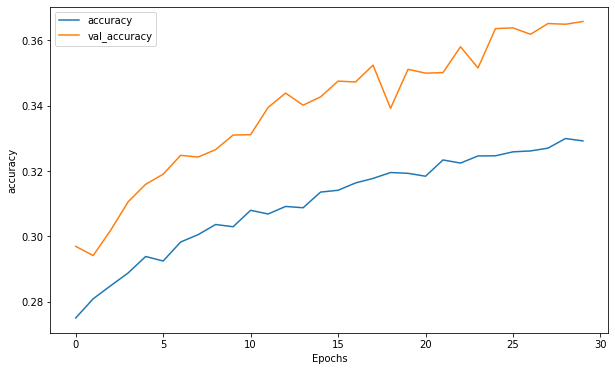

In [37]:
plot_history(history, 'accuracy')

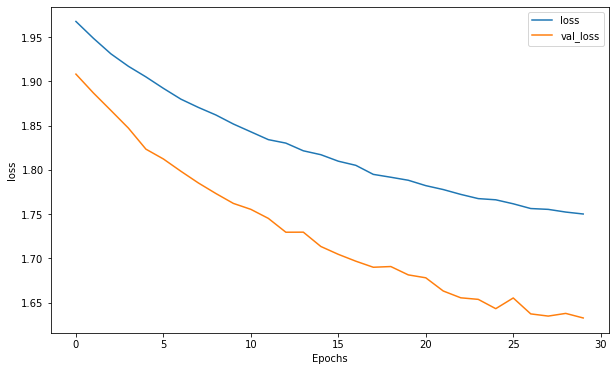

In [36]:
plot_history(history, 'loss')

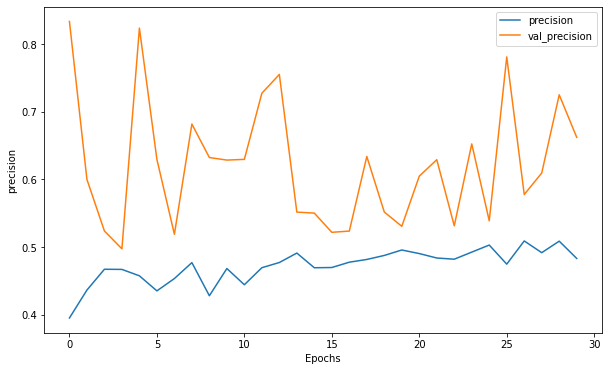

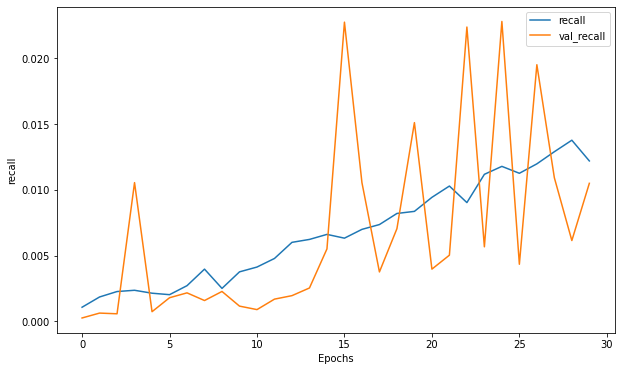

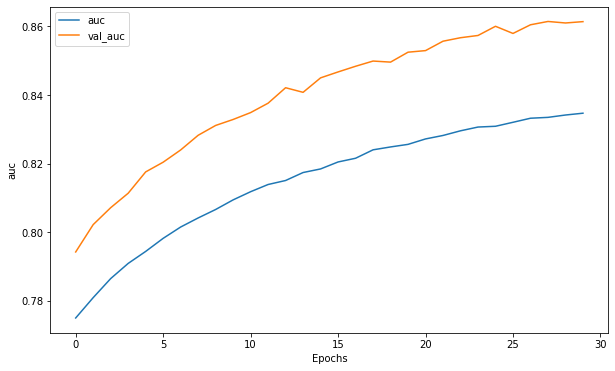

In [38]:
plot_history(history, 'precision')
plot_history(history, 'recall')
plot_history(history, 'auc')

In [ ]:
# evaluate the model
test_loss, test_accuracy = model.evaluate(x_train, y_train)
evaluate_lst = list(map(lambda x: x * 100, [test_loss, test_accuracy]))
print('\nTest:\nLoss: {}\nAccuracy: {}').format(evaluate_lst[0], evaluate_lst[1])

In [ ]:
# predict
s = 'happy'
pred = predict(label_dict, s, model)
print('Word: {}'.format(s))
print('Prediction: {}'.format(pred))

In [ ]:
# evaluation confusion matrix
tf.math.confusion_matrix(labels=y_validation, predictions=x_validation)

In [ ]:
# save the model
!mkdir models
model.save(MODEL_PATH)

In [ ]:
# convert to modeljs
tfjs.converters.save_keras_model(model, 'tfjsmodel')